In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


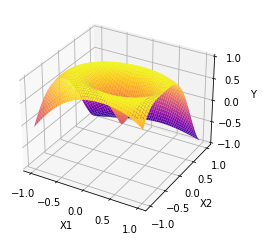

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

### Developing shift based istereographic

In [7]:
class DistanceTransform_KNNnegExp_epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers+1)*3/3))
        self.scaler = nn.Parameter(torch.log(torch.rand(1, 1)*1))

        self.bias = nn.Parameter(torch.ones(1, num_centers+1)*0) if bias else None
#         self.bias = nn.Parameter(torch.randn(1, num_centers+1)*0.1) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)

#         dists = torch.exp(-dists**2+self.scaler) ## the gaussian

#         dists = torch.exp(-(dists.abs())+self.scaler) ## works well with sqrt scaling or without
        dists = (1-dists)*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists


In [8]:
t = DistanceTransform_KNNnegExp_epsilon(2, 5, epsilon=1.0)

In [9]:
t(torch.randn(7, 2)).shape

torch.Size([7, 6])

In [10]:
t(torch.randn(7, 2))

tensor([[-0.0112, -0.0043, -0.0089, -0.0067, -0.0066,  0.0000],
        [-0.0193, -0.0026,  0.0030,  0.0004,  0.0002,  0.0000],
        [ 0.0260,  0.0058, -0.0010,  0.0023,  0.0029,  0.0000],
        [-0.0181,  0.0068,  0.0139,  0.0105,  0.0100,  0.0000],
        [-0.0171, -0.0052, -0.0083, -0.0068, -0.0069,  0.0000],
        [ 0.0152, -0.0074, -0.0144, -0.0110, -0.0105,  0.0000],
        [ 0.0040, -0.0042, -0.0063, -0.0050, -0.0046,  0.0000]],
       grad_fn=<MulBackward0>)

## Building 2D model

In [11]:
2**(-torch.arange(5, dtype=torch.float32)).expand(3, 5)

tensor([[1.0000, 0.5000, 0.2500, 0.1250, 0.0625],
        [1.0000, 0.5000, 0.2500, 0.1250, 0.0625],
        [1.0000, 0.5000, 0.2500, 0.1250, 0.0625]])

In [12]:
# https://stackoverflow.com/questions/52127723/pytorch-better-way-to-get-back-original-tensor-order-after-torch-sort
original = torch.tensor([
    [20, 22, 24, 21],
    [12, 14, 10, 11],
    [34, 31, 30, 32]])
dim = 1
sorted, index = original.sort(dim=dim)
unsorted = sorted.gather(dim, index.argsort(dim))
torch.all(original == unsorted)

tensor(True)

In [13]:
x = -torch.rand(1, 5)
nex = 2**(-torch.arange(x.shape[1], dtype=x.dtype)).expand_as(x)
x, nex

(tensor([[-0.2174, -0.0294, -0.3769, -0.9994, -0.6936]]),
 tensor([[1.0000, 0.5000, 0.2500, 0.1250, 0.0625]]))

In [14]:
dim = 1
s, i = x.sort(dim=dim, descending=True)
s, i

(tensor([[-0.0294, -0.2174, -0.3769, -0.6936, -0.9994]]),
 tensor([[1, 0, 2, 4, 3]]))

In [15]:
s.gather(1, i.argsort(dim))

tensor([[-0.2174, -0.0294, -0.3769, -0.9994, -0.6936]])

In [16]:
nex.gather(1, i.argsort(dim))

tensor([[0.5000, 1.0000, 0.2500, 0.0625, 0.1250]])

In [17]:
class KNN_negExp(nn.Module):
    
    def forward(self, x):
        ## x -> [BS, DIM]
        s, i = torch.sort(x, dim=1, descending=True)
#         neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)).expand_as(x)
        neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)-1).expand_as(x)
        y = neg_exp.gather(1, i.argsort(dim))
        return y

In [18]:
class LocalMLP_knn(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_KNNnegExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.knn_exp = KNN_negExp()
        
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.activ = nn.ReLU()
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
#         print(xo.shape)
        xo = self.knn_exp(xo)
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [19]:
model = LocalMLP_knn(2, 10, 1, epsilon=0.1).to(device)

In [20]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [21]:
model

LocalMLP_knn(
  (layer0): DistanceTransform_KNNnegExp_epsilon()
  (knn_exp): KNN_negExp()
  (activ): ReLU()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

## Overfitting

In [22]:
criterion = nn.MSELoss()

In [23]:
H = 10
model = LocalMLP_knn(2, H, 1, epsilon=3.0)

In [24]:
randidx = torch.randperm(len(xx))[:H]
model.layer0.centers.data = xx[randidx] 
_yy = torch.cat([yy[randidx], torch.zeros(1, yy.shape[1])], dim=0)
model.layer1.weight.data = _yy.t()

In [25]:
model.layer1.bias.data *= 0.

In [26]:
yout = model(xx)
loss = criterion(yout, yy)
loss

tensor(0.3911, grad_fn=<MseLossBackward>)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


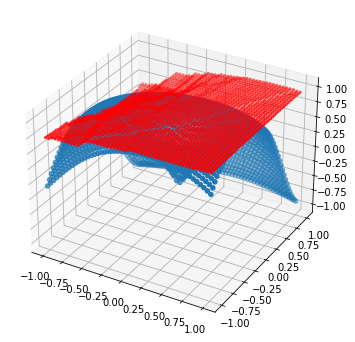

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## 1. Classification

In [28]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

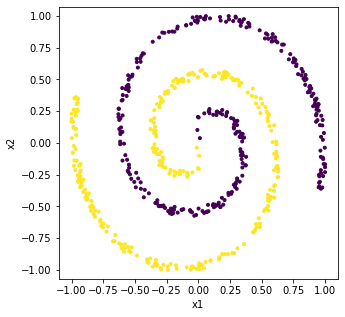

In [29]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [30]:
xx, yy = xx.to(device), yy.to(device)

#### Random Init

In [31]:
H = 10
model = LocalMLP_knn(2, H, 1, epsilon=0.5)
model

LocalMLP_knn(
  (layer0): DistanceTransform_KNNnegExp_epsilon()
  (knn_exp): KNN_negExp()
  (activ): ReLU()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [32]:
randidx = torch.randperm(len(xx))[:H]

In [33]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.24868939816951752, 0.6166666746139526)

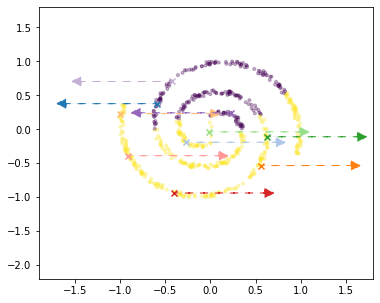

In [34]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [35]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

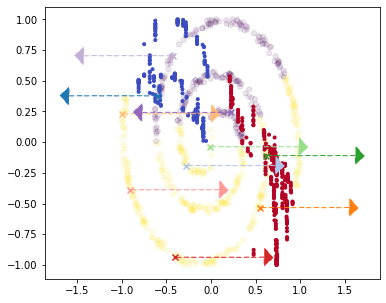

In [36]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [37]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.knn_exp(xo)
    return xo

In [38]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([0.0725, 0.1116, 0.0776, 0.0395, 0.1010, 0.0857, 0.0635, 0.0603, 0.1235,
        0.0678, 0.1966]) 
  tensor([0.1398, 0.1732, 0.1516, 0.1058, 0.1607, 0.0938, 0.1430, 0.1391, 0.1693,
        0.1377, 0.1377])
tensor([0.0010, 0.0039, 0.0005, 0.0005, 0.0005, 0.0078, 0.0005, 0.0005, 0.0010,
        0.0005, 0.0312]) 
  tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000])


In [39]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [40]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

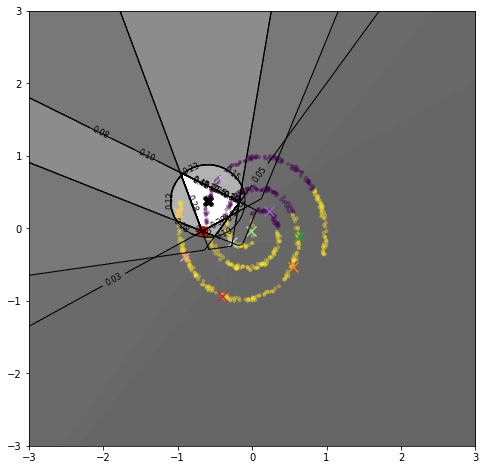

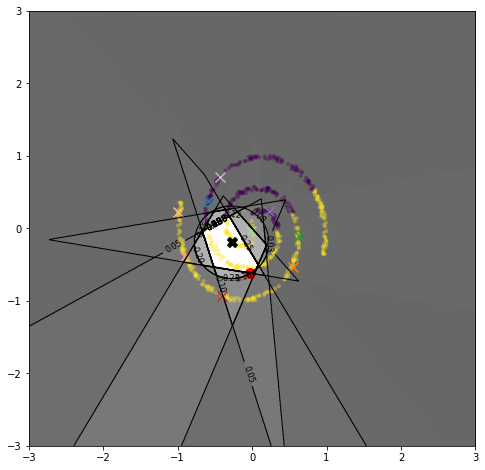

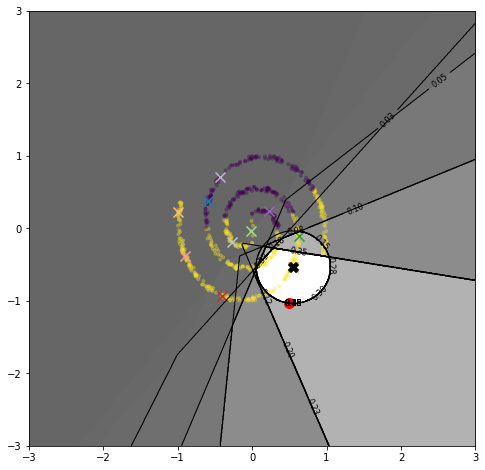

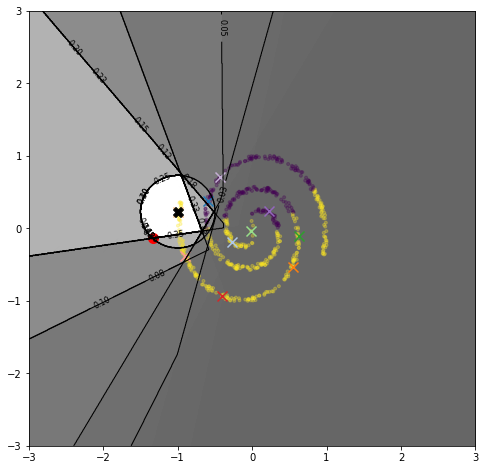

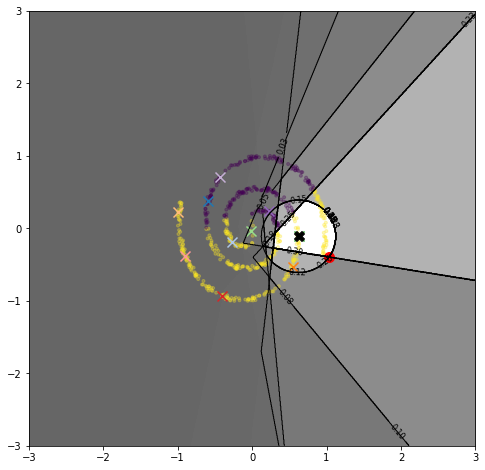

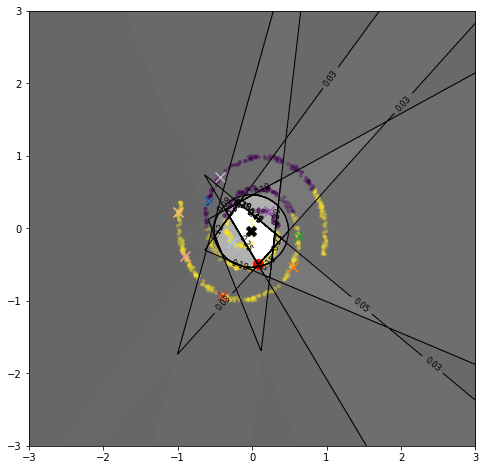

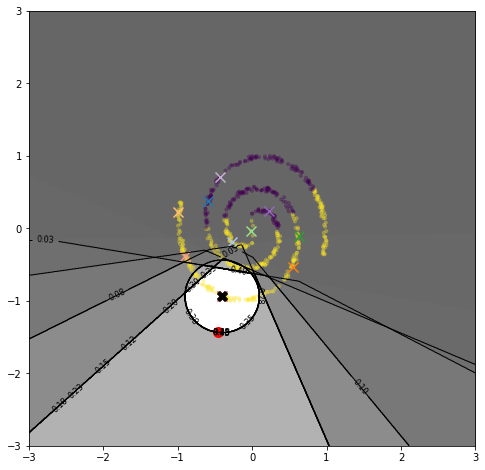

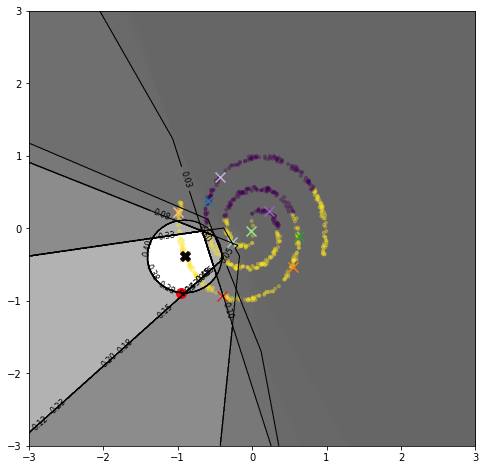

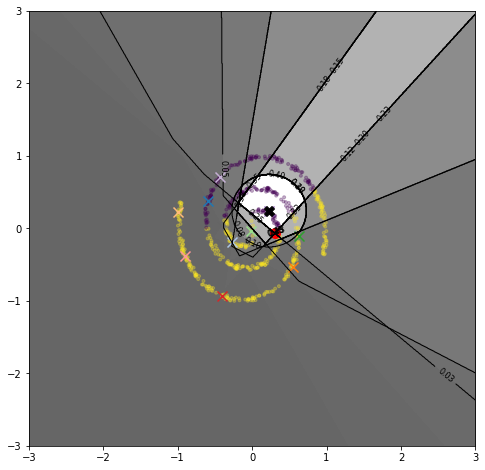

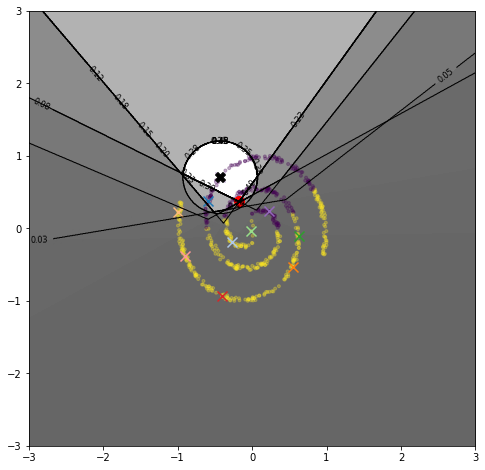

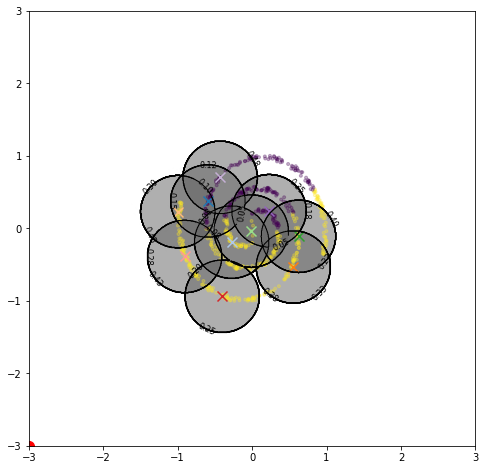

In [41]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
#     print(conf.shape)
    
    ax = plt.figure(figsize=(8,8)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [42]:
model

LocalMLP_knn(
  (layer0): DistanceTransform_KNNnegExp_epsilon()
  (knn_exp): KNN_negExp()
  (activ): ReLU()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

## Straight Through for KNN_negExp

In [43]:
# class KNN_negExp(nn.Module):
    
#     def forward(self, x):
#         ## x -> [BS, DIM]
#         s, i = torch.sort(x, dim=1, descending=True)
# #         neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)).expand_as(x)
#         neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)-1).expand_as(x)
#         y = neg_exp.gather(1, i.argsort(dim))
#         return y

In [44]:
class KNN_negExp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        s, i = torch.sort(x, dim=1, descending=True)
        neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)).expand_as(x)
#         neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype)-1).expand_as(x)
        y = neg_exp.gather(1, i.argsort(dim))
    
        ctx.save_for_backward(y)
        return y

    @staticmethod
    def backward(ctx, grad_out):
        y, = ctx.saved_tensors
#         return y * grad_out
        return grad_out

In [45]:
class LocalMLP_knn(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_KNNnegExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.knn_exp = KNN_negExp.apply
        
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='exp_1.6')
#         self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.activ = nn.Sequential(
            dtnn.ScaleShift(self.hidden_dim+1),
            nn.LeakyReLU(),
        )
    
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
#         print(xo.shape)
        xo = self.knn_exp(xo)
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

## Train Classifier

In [46]:
H = 10
model = LocalMLP_knn(2, H, 1, epsilon=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

criterion = nn.BCELoss()

In [47]:
randidx = torch.randperm(len(xx))[:H]

In [48]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
model.layer1.bias.data *= 0.

Epoch: 99, Acc:0.66, Loss:0.6193298697471619
Epoch: 199, Acc:0.65, Loss:0.6066613793373108
Epoch: 299, Acc:0.66, Loss:0.5575317144393921
Epoch: 399, Acc:0.67, Loss:0.5297651886940002
Epoch: 499, Acc:0.70, Loss:0.5191267132759094
Epoch: 599, Acc:0.80, Loss:0.4830377697944641
Epoch: 699, Acc:0.86, Loss:0.4627445936203003
Epoch: 799, Acc:0.89, Loss:0.4457136392593384
Epoch: 899, Acc:0.79, Loss:0.4904945492744446
Epoch: 999, Acc:0.72, Loss:0.556647002696991


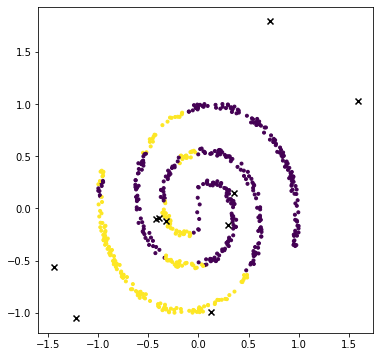

Epoch: 1099, Acc:0.77, Loss:0.5791093707084656
Epoch: 1199, Acc:0.72, Loss:0.5733250975608826
Epoch: 1299, Acc:0.64, Loss:0.6067551970481873
Epoch: 1399, Acc:0.67, Loss:0.6014701128005981
Epoch: 1499, Acc:0.65, Loss:0.5863022208213806
Epoch: 1599, Acc:0.69, Loss:0.572343111038208
Epoch: 1699, Acc:0.67, Loss:0.5695720911026001
Epoch: 1799, Acc:0.63, Loss:0.5681399703025818
Epoch: 1899, Acc:0.63, Loss:0.5853114128112793
Epoch: 1999, Acc:0.62, Loss:0.5968338847160339


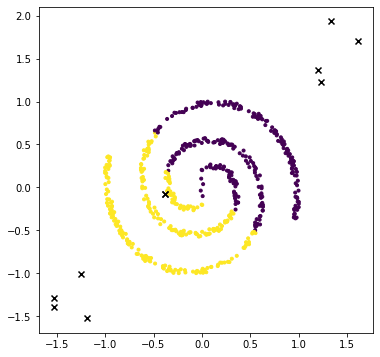

Epoch: 2099, Acc:0.64, Loss:0.5814639925956726
Epoch: 2199, Acc:0.63, Loss:0.5956394672393799
Epoch: 2299, Acc:0.64, Loss:0.5877416729927063
Epoch: 2399, Acc:0.64, Loss:0.5960859060287476
Epoch: 2499, Acc:0.64, Loss:0.6136821508407593
Epoch: 2599, Acc:0.64, Loss:0.6135092377662659
Epoch: 2699, Acc:0.71, Loss:0.6320742964744568
Epoch: 2799, Acc:0.68, Loss:0.6264178156852722
Epoch: 2899, Acc:0.65, Loss:0.633819043636322
Epoch: 2999, Acc:0.65, Loss:0.6444749236106873


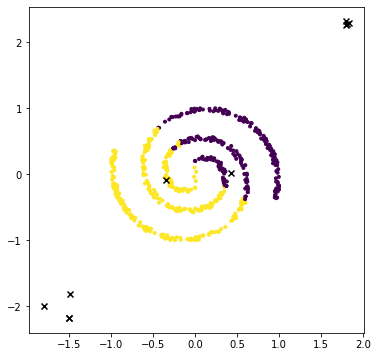

Epoch: 3099, Acc:0.66, Loss:0.6464055180549622
Epoch: 3199, Acc:0.65, Loss:0.6568194031715393
Epoch: 3299, Acc:0.64, Loss:0.6471232175827026
Epoch: 3399, Acc:0.65, Loss:0.6341851949691772
Epoch: 3499, Acc:0.65, Loss:0.6335179209709167
Epoch: 3599, Acc:0.66, Loss:0.6263316869735718
Epoch: 3699, Acc:0.66, Loss:0.6210422515869141
Epoch: 3799, Acc:0.65, Loss:0.6200955510139465
Epoch: 3899, Acc:0.66, Loss:0.6131742596626282
Epoch: 3999, Acc:0.65, Loss:0.6079085469245911


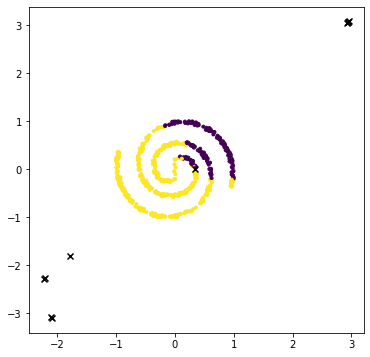

Epoch: 4099, Acc:0.66, Loss:0.5995065569877625
Epoch: 4199, Acc:0.66, Loss:0.5903653502464294
Epoch: 4299, Acc:0.66, Loss:0.5824578404426575
Epoch: 4399, Acc:0.69, Loss:0.5784452557563782
Epoch: 4499, Acc:0.69, Loss:0.5690205097198486
Epoch: 4599, Acc:0.68, Loss:0.5767536163330078
Epoch: 4699, Acc:0.68, Loss:0.5764122009277344
Epoch: 4799, Acc:0.69, Loss:0.5613731741905212
Epoch: 4899, Acc:0.70, Loss:0.5546829104423523
Epoch: 4999, Acc:0.69, Loss:0.5543007254600525


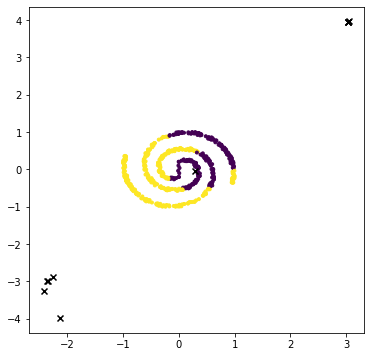

In [49]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

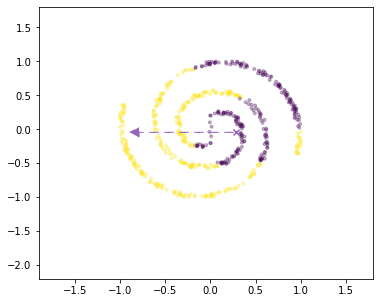

In [50]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)
plt.show()

In [51]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.knn_exp(xo).data
    return xo

In [52]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([0.0127, 0.0984, 0.0239, 0.0099, 0.0592, 0.0380, 0.0381, 0.0063, 0.6167,
        0.2125, 0.8833]) 
  tensor([0.0220, 0.0453, 0.0127, 0.0071, 0.0315, 0.0714, 0.0701, 0.0110, 0.2117,
        0.0859, 0.2117])
tensor([0.0020, 0.0078, 0.0020, 0.0010, 0.0039, 0.0039, 0.0039, 0.0010, 0.5000,
        0.0156, 0.5000]) 
  tensor([0.0625, 0.1250, 0.0312, 0.0156, 0.1250, 0.2500, 0.2500, 0.0312, 1.0000,
        0.2500, 1.0000])


In [53]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [54]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

(1000, 1000)


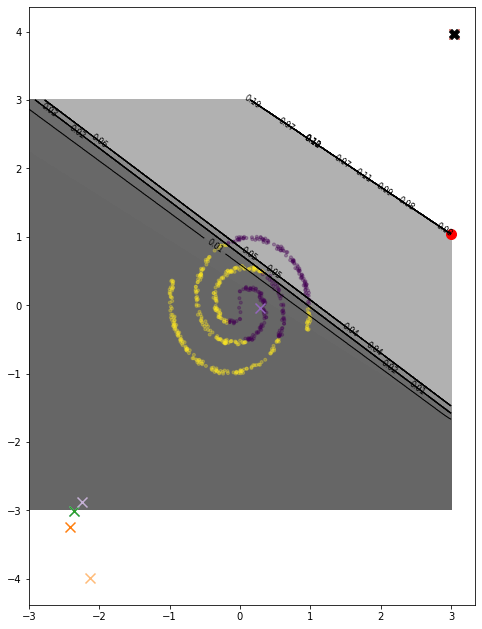

(1000, 1000)


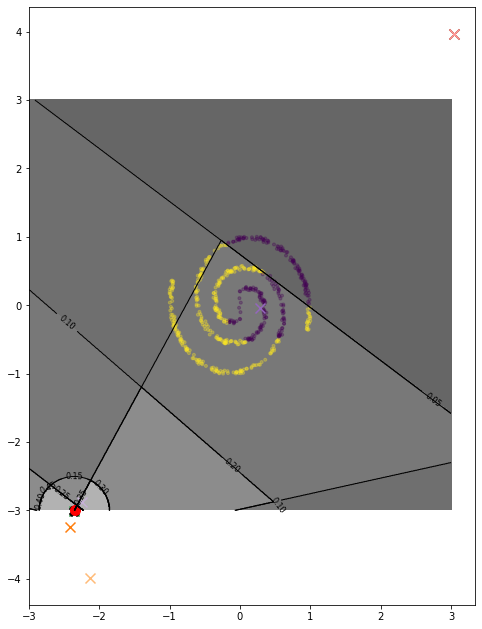

(1000, 1000)


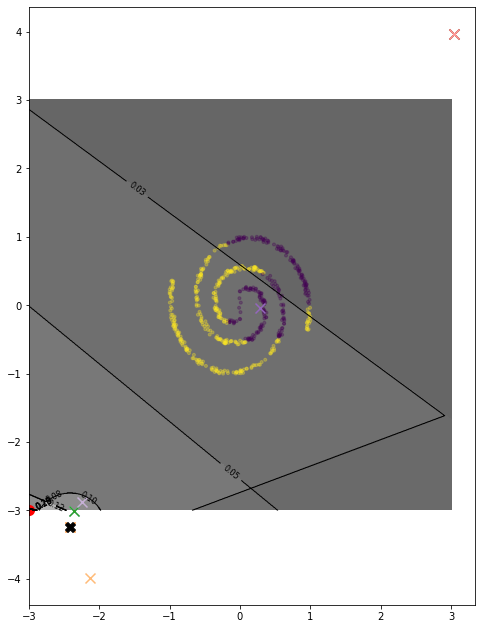

(1000, 1000)


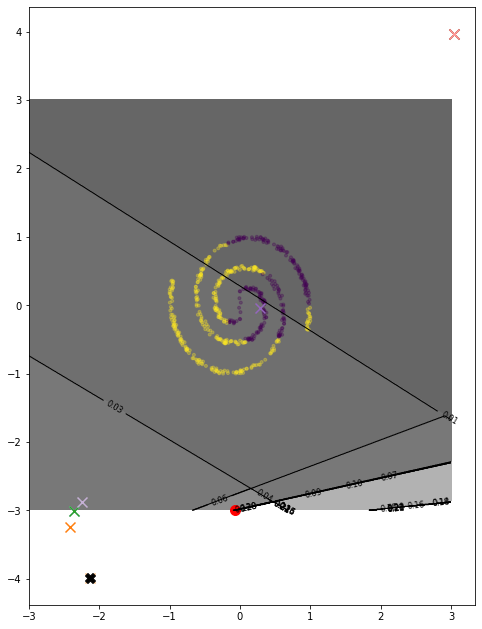

(1000, 1000)


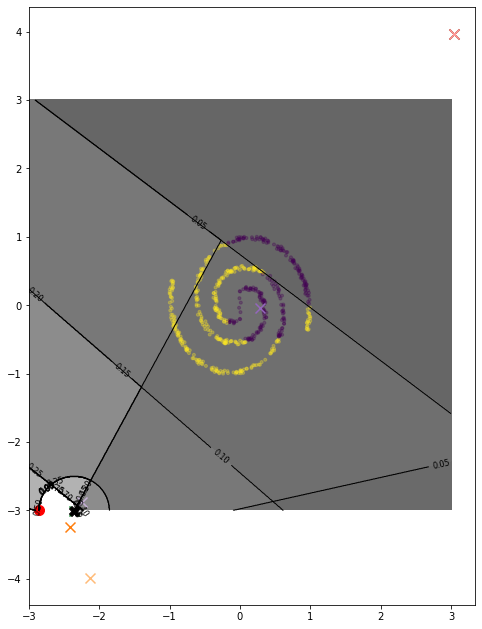

(1000, 1000)


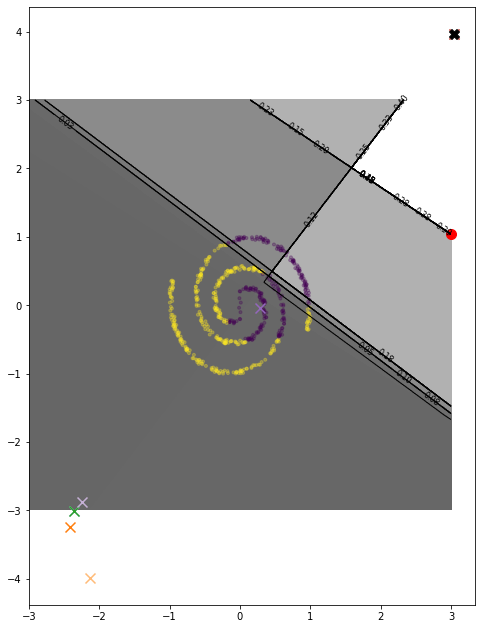

(1000, 1000)


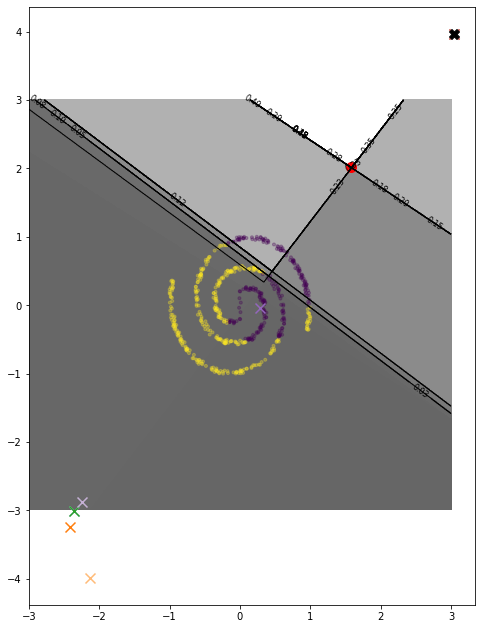

(1000, 1000)


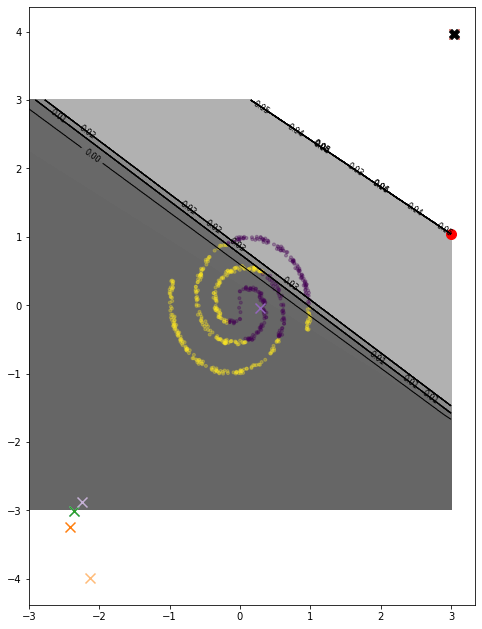

(1000, 1000)


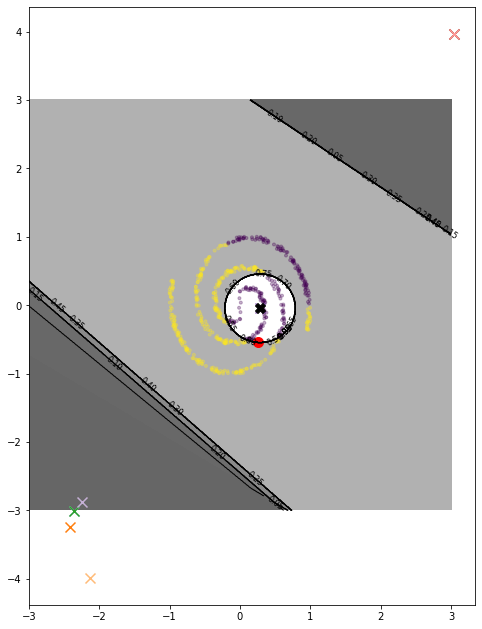

(1000, 1000)


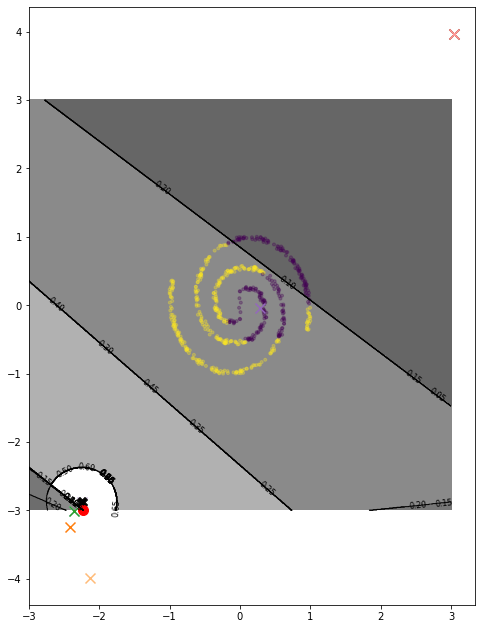

(1000, 1000)


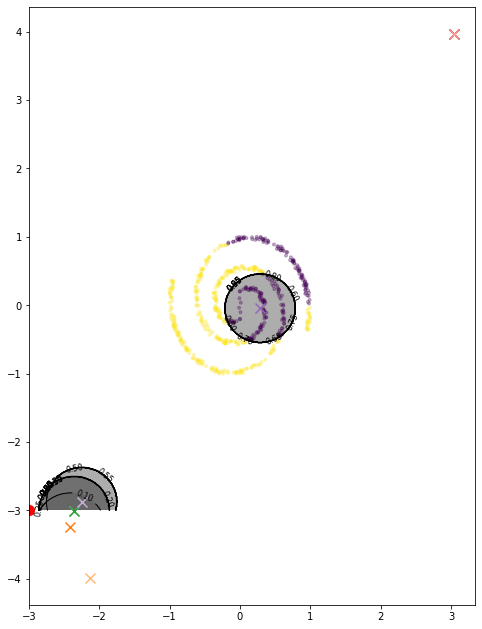

In [55]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [56]:
"""
The sorting preserves the monotonicity of the input activations (like non-linear function)
Can use any monotonicity preserving function for all of activation to use in DistanceTransform.
"""

'\nThe sorting preserves the monotonicity of the input activations (like non-linear function)\nCan use any monotonicity preserving function for all of activation to use in DistanceTransform.\n'